# Beach Trash Detector - Final Project

**Description**: Life at the oceans is not as safe as it used to be before human kind started to polute the oceans, beaches and seas. The garbage throw at the beach, usually ends in the ocean and it is harmful to all animals and the enviroment, with that in mind my idea is to develop a computer vision software to recognize trash at the beach, and with the help of a drone recognize this trash and save its locations, so that someone can pickup, or another drones could do that job, why not.



# Configuring Google Colab


In [ ]:
# Configuring Google Colab
%tensorflow_version 1.15
!pip install keras==2.1.0

from google.colab import drive
drive.mount('/content/drive')

# Loading Dataset

In [45]:
import json

ROOT_PATH = '/content/drive/My Drive/'
DATASET_PATH = ROOT_PATH + 'trash/dataset/'
MODEL_PATH = ROOT_PATH + 'trash/model/'
ANNOTATIONS_JSON = DATASET_PATH + 'annotations.json'

with open(ANNOTATIONS_JSON, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
annotations = dataset['annotations']
images = dataset['images']
print(f'categories: {len(categories)}\nannotations: {len(annotations)}\nimages: {len(images)}')

categories: 60
annotations: 4784
images: 1500


In [ ]:
# Download Dataset Images from json

import os
from io import BytesIO

import requests
from PIL import Image

nr_images = len(dataset['images'])
for i in range(nr_images):
    image = dataset['images'][i]

    file_name = image['file_name']
    url_original = image['flickr_url']
    url_resized = image['flickr_640_url']

    file_path = os.path.join(DATASET_PATH, file_name)

    # Create subdir if necessary
    subdir = os.path.dirname(file_path)
    if not os.path.isdir(subdir):
        os.mkdir(subdir)

    if not os.path.isfile(file_path):
        # Load and Save Image
        response = requests.get(url_original)
        img = Image.open(BytesIO(response.content))
        if img._getexif():
            img.save(file_path, exif=img.info["exif"])
        else:
            img.save(file_path)

    # Show loading bar
    bar_size = 30
    x = int(bar_size * i / nr_images)
    print("%s[%s%s] - %i/%i\r" % ('Loading: ', "=" * x, "." * (bar_size - x), i, nr_images))
    i+=1

In [39]:
from pycocotools.coco import COCO
coco_annotation = COCO(annotation_file=ANNOTATIONS_JSON)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [40]:
# Create Dataset Class for Mask_Rcnn
import skimage
from mrcnn.utils import Dataset

class TrashDataset(Dataset):
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "trash")
        # define data locations
        # find all images
        imgs = list(coco_annotation.imgToAnns.values())
        if is_train:
            imgs = imgs[:500]
        else:
            imgs = imgs[500:]
        for img in imgs:
            # extract image id
            image_id = img[0]['image_id']
            image_data = coco_annotation.loadImgs([image_id])[0]
            segmentations = []
            for i in img:
                x = []
                y = []
                for j, k in enumerate(i['segmentation'][0]):
                    if j % 2 ==0:
                        x.append(k)
                    else:
                        y.append(k)
                segmentations.append({'all_points_x': x, 'all_points_y': y})

            image_path = dataset_dir + image_data['file_name']
            height = image_data['height']
            width = image_data['width']        
            if os.path.exists(image_path):
              self.add_image(
                  "dataset",
                  image_id=image_data['file_name'],  # use file name as a unique image id
                  path=image_path,
                  width=width, height=height,
                  polygons=segmentations)
            
    def load_mask(self, image_id):
        """Generate instance masks for an image.
            Returns:
            masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "dataset":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)
    
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "database":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [41]:
dataset = TrashDataset()
dataset.load_dataset(DATASET_PATH, is_train=True)
dataset.prepare()

dataset_val = TrashDataset()
dataset_val.load_dataset(DATASET_PATH, is_train=False)
dataset_val.prepare()

In [42]:
# Show Dataset Numbers

print("Image Count: {}".format(len(dataset.image_ids)))
print("Image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 500
Image Count: 1000
Class Count: 2
  0. BG                                                
  1. trash                                             


# Inspecting Dataset Data

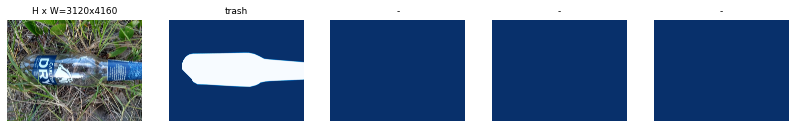

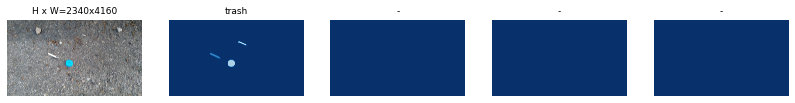

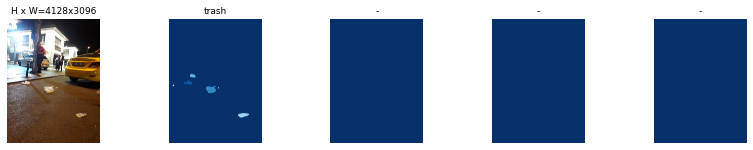

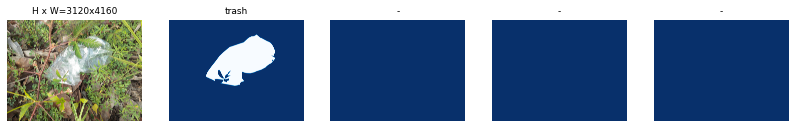

In [43]:
import numpy as np
from mrcnn import visualize

image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  6 None


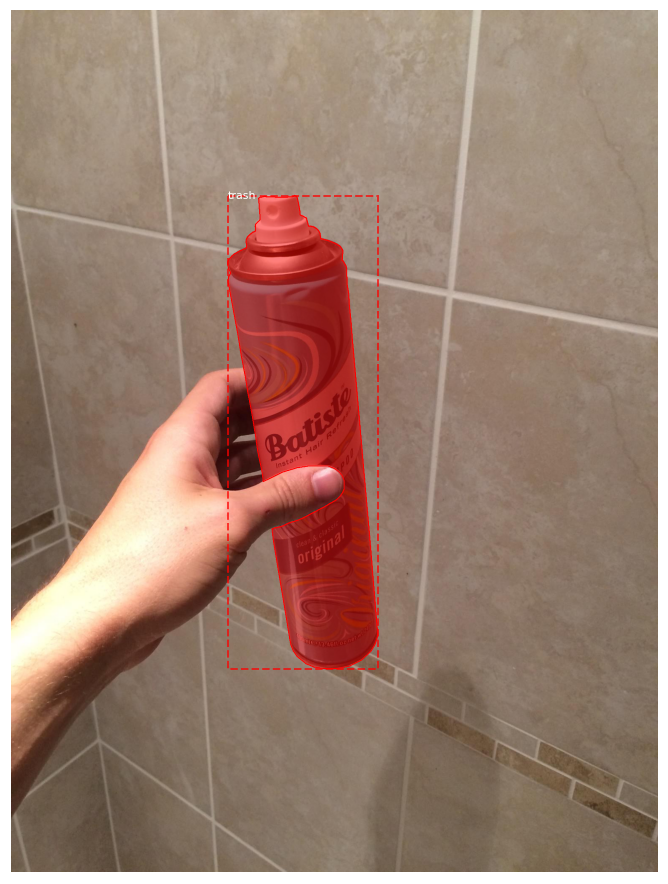

In [44]:
import random

from mrcnn.utils import extract_bboxes

image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Training Model

In [14]:
from mrcnn.config import Config

class TrashConfig(Config):
    NAME = "TrashConfig"
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    RPN_ANCHOR_RATIOS = [0.5, 1, 2]
    NUM_CLASSES = 1 + 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 100

config = TrashConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [46]:
# Download Coco Weights if necessary

COCO_MODEL_PATH = DATASET_PATH + 'mask_rcnn_coco.h5'
if not os.path.exists(COCO_MODEL_PATH):
    download_trained_weights(COCO_MODEL_PATH)


In [48]:
from mrcnn import model as modellib

# tf.disable_v2_behavior() 

model = modellib.MaskRCNN(mode="training", model_dir=MODEL_PATH, config=config)
weights_path = model.find_last()
# Load weights trained on MS-COCO removing last layers
if os.path.exists(weights_path):
    print(f"Loading existing weights: {weights_path}")
    model.load_weights(weights_path, by_name=True)
else:
    print(f"Loading coco weights")
    model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

Loading existing weights: /content/drive/My Drive/trash/model/trashconfig20200720T2229/mask_rcnn_trashconfig_0006.h5
Re-starting from epoch 6


In [ ]:
model.train(dataset, dataset_val, learning_rate=config.LEARNING_RATE, epochs=6, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/trash/model/trashconfig20200720T2229/mask_rcnn_trashconfig_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDist

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/6
 99/100 [============================>.] - ETA: 49s - loss: 1.6145 - rpn_class_loss: 0.1470 - rpn_bbox_loss: 0.3671 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.6083 - mrcnn_mask_loss: 0.3942 

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



100/100 [==============================] - 5852s 59s/step - loss: 1.6190 - rpn_class_loss: 0.1458 - rpn_bbox_loss: 0.3697 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.6074 - mrcnn_mask_loss: 0.3985 - val_loss: 1.5234 - val_rpn_class_loss: 0.1868 - val_rpn_bbox_loss: 0.5587 - val_mrcnn_class_loss: 0.0735 - val_mrcnn_bbox_loss: 0.4444 - val_mrcnn_mask_loss: 0.2599
Epoch 2/6
100/100 [==============================] - 5723s 57s/step - loss: 1.2610 - rpn_class_loss: 0.1403 - rpn_bbox_loss: 0.4399 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.3855 - mrcnn_mask_loss: 0.2165 - val_loss: 1.3791 - val_rpn_class_loss: 0.1242 - val_rpn_bbox_loss: 0.5932 - val_mrcnn_class_loss: 0.0625 - val_mrcnn_bbox_loss: 0.3559 - val_mrcnn_mask_loss: 0.2433
Epoch 3/6
100/100 [==============================] - 5765s 58s/step - loss: 1.2209 - rpn_class_loss: 0.1368 - rpn_bbox_loss: 0.4239 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.3308 - mrcnn_mask_loss: 0.2575 - val_loss: 1.7100 - val_rpn_class_loss: 0

# Validating Model

In [49]:
# Create Inference model with trained weights

model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_PATH, config=config)
weights_path = model.find_last()
model.load_weights(weights_path, by_name=True)

Re-starting from epoch 6


['BG', 'trash']


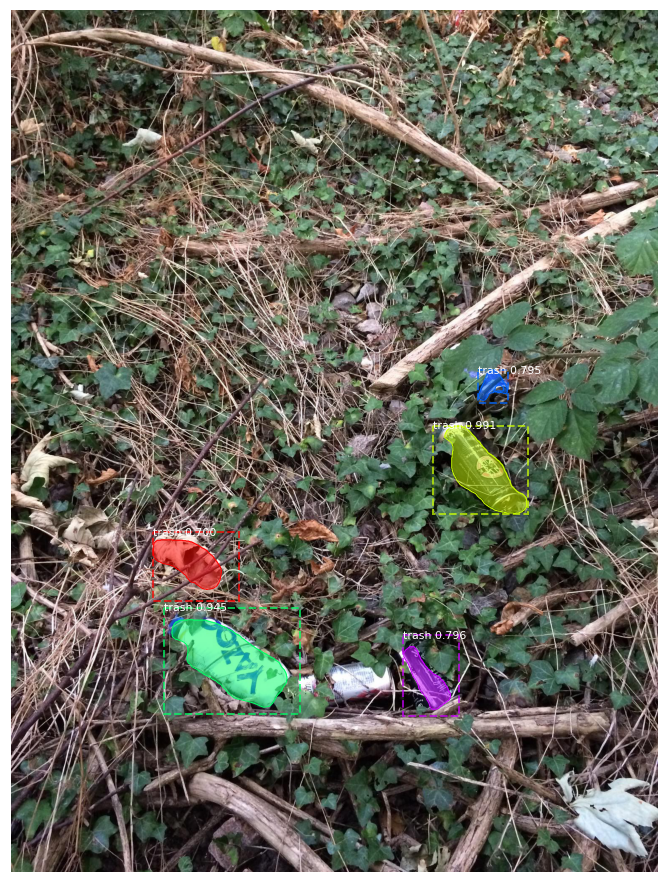

In [21]:
# Testing Detection on a single Image

image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
results = model.detect([image], verbose=0)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'])

In [ ]:
# Calculate Precision using MRCNN tool

from mrcnn.utils import compute_ap

image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))